In [1]:
# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'

from pathlib import Path

In [2]:
# Marginal params
marginal_params = 'position'

# Loss function
opt_param = 'pupil.coefficients'
@zdx.filter_jit
@zdx.filter_value_and_grad(opt_param)

def fim_loss_func(optics, sources, detector, parameters):
    covs = []
    for source in sources:
        model = dl.Telescope(optics, source, detector)
        data = model.model()
        cov = zdx.covariance_matrix(model, parameters, poiss_loglike, data=data)
        covs.append(cov)

    # convert list -> array: shape (n_sources, n_params, n_params)
    covs_arr = np.stack(covs)   # or np.asarray(covs)

    # trace over the last two axes to get one trace per source
    traces = np.trace(covs_arr, axis1=-2, axis2=-1)   # shape (n_sources,)

    # average of the top-k traces (k=10)
    k = 5
    traces_sorted = np.sort(traces)   # ascending
    topk = traces_sorted[-k:]         # if n_sources < k this returns all traces
    avg_topk = np.mean(topk)


    # log it
    loss = np.log10(avg_topk)

    return loss

In [32]:
n_sources = 20
key = jr.PRNGKey(7)

positions = jr.uniform(key, (n_sources,2))

print(positions)
wf_npix = 256 
diameter = 0.125 # This is default of toliman optical system. Can change.

### Can apply these to the input if you just want a clear aperture
m2_diameter = 0
strut_width = 0
###

wavelength = 585e-9

# This is to what degree we undersample Nyquist
nyquist_factor = 16
psf_npix = 256 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

# Place the source in the centre of the top right from center pixel.
# That's what the position argument does here
sources = []
for i in np.arange(n_sources):
    position = positions[i]
    source = dl.PointSource(flux=1e6,position=dlu.arcsec2rad(psf_pixel_scale*position),wavelengths=np.array([wavelength]))
    sources.append(source)

# Optimisable binary mask
# climb_basis = np.load("../xk4/files/basis.npy")
climb_basis = np.load("bases/basis1.npy")

# reasonable coefficient: 2e-5
coefficients = (2e-5)*jr.normal(key, [len(climb_basis)])
mean_wl = source.wavelengths.mean()

# have to make sure that mean_wl is in meters.
mask_layer = ApplyBasisCLIMB(climb_basis, mean_wl, coefficients)

# Construct instrument
optics = TolimanOpticalSystem(wf_npixels=wf_npix,psf_npixels=psf_npix, mask=mask_layer, psf_pixel_scale=psf_pixel_scale, oversample=oversample)

# detector layer
detector_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(oversample)
    )
]

detector = dl.LayeredDetector(layers = detector_layers)

[[0.74840785 0.85123669]
 [0.42426377 0.05868164]
 [0.86606641 0.92285356]
 [0.76456672 0.76790147]
 [0.56092513 0.13838021]
 [0.46378566 0.47837662]
 [0.94138501 0.38553289]
 [0.13903165 0.99353882]
 [0.08851734 0.30852152]
 [0.27677409 0.86208947]
 [0.90767403 0.44522241]
 [0.79036662 0.94926585]
 [0.67070473 0.47830185]
 [0.70424245 0.55237159]
 [0.33463459 0.61682356]
 [0.74634104 0.15166807]
 [0.61672306 0.37170175]
 [0.65975944 0.66531995]
 [0.32250398 0.27457019]
 [0.19281448 0.89909794]]


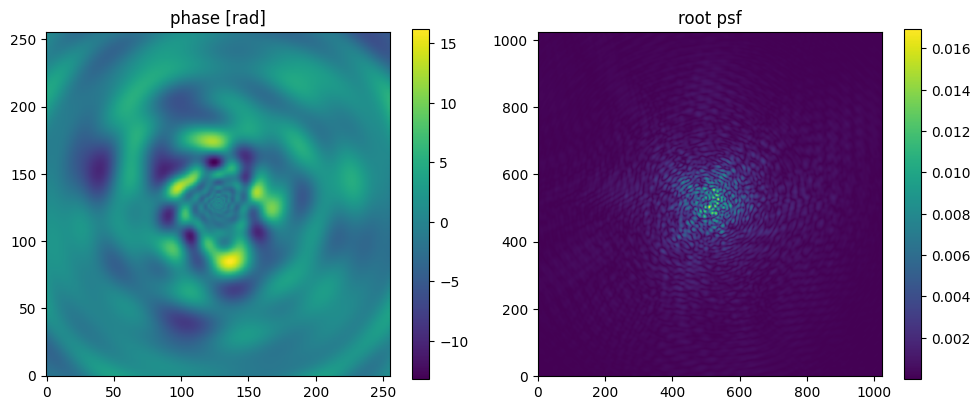

In [33]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title('phase [rad]')
plt.imshow(dlu.opd2phase(dlu.downsample(optics.get_total_opd(),3,True),585e-9))
plt.colorbar()

plt.subplot(1,2,2)
plt.title('root psf')
plt.imshow(dlu.downsample(optics.propagate_mono(585e-9)**0.5,1,False))
# plt.xlim(512-256,512+256)
# plt.ylim(512-256,512+256)
plt.colorbar()

plt.tight_layout()
plt.show()

In [35]:
#fim_loss_func(optics, sources, detector, marginal_params)

optim, opt_state = zdx.get_optimiser(optics, opt_param, optax.adam(4e-6))

losses, models_out = [], [optics]
with tqdm(range(200), desc='Gradient Descent') as t:
    for i in t:
        loss, grads = fim_loss_func(optics, sources, detector, marginal_params)
        updates, opt_state = optim.update(grads, opt_state)   # your zdx API
        optics = zdx.apply_updates(optics, updates)
        models_out.append(optics)
        losses.append(loss)
        t.set_description("Loss: {:.6f}".format(float(loss)))

Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
plt.plot(losses)

In [36]:
trace_covs = []

detector_nyq_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(64)
    )
]

detector_nyq = dl.LayeredDetector(layers = detector_nyq_layers)

for source in sources:
    traces = []
    for optics in models_out[::200]:

        model = dl.Telescope(optics, source, detector_nyq)

        data = model.model()
        cov = zdx.covariance_matrix(model, marginal_params, poiss_loglike, data=data)
        trace = np.trace(cov)
        traces.append(trace)
        print('tick')

    trace_covs.append(traces)

tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick
tick


In [43]:
# Airy:
coords = dlu.pixel_coords(wf_npix, diameter)
airy_aperture = dlu.circle(coords, 0.5*diameter)
airy_layers = [
    (
        'aperture',
        dl.TransmissiveLayer(airy_aperture,normalise=True)
    )
]
optics_airy = dl.AngularOpticalSystem(wf_npixels = wf_npix, diameter = diameter, layers=airy_layers,
                                      psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)

# Zernike defocus
import dLuxToliman as dlT
defocus_layers = [
    (
        'aperture',
        dlT.TolimanApertureLayer(wf_npix)
    ),
    (
        'defocus',
        dl.AberratedLayer(opd = 0.45*0.75*wavelength*dlu.zernike(4,coords,diameter))
    )
]
optics_defocus = dl.AngularOpticalSystem(wf_npixels = wf_npix, diameter = diameter, layers=defocus_layers,
                                      psf_npixels=psf_npix,psf_pixel_scale=psf_pixel_scale,oversample=oversample)


traces_airy = []
traces_defocus = []
for source in sources:

    model_airy = dl.Telescope(optics_airy,source,detector_nyq)

    data_airy = model_airy.model()
    covs_airy = zdx.covariance_matrix(model_airy, marginal_params, poiss_loglike, data=data_airy)
    trace_airy = np.trace(covs_airy)
    traces_airy.append(trace_airy)

    model_defocus = dl.Telescope(optics_defocus, source, detector_nyq)
    data_defocus = model_defocus.model()
    covs_defocus = zdx.covariance_matrix(model_defocus, marginal_params, poiss_loglike, data=data_defocus)
    trace_defocus = np.trace(covs_defocus)
    traces_defocus.append(trace_defocus)

traces_airy = np.asarray(traces_airy)
traces_defocus = np.asarray(traces_defocus)

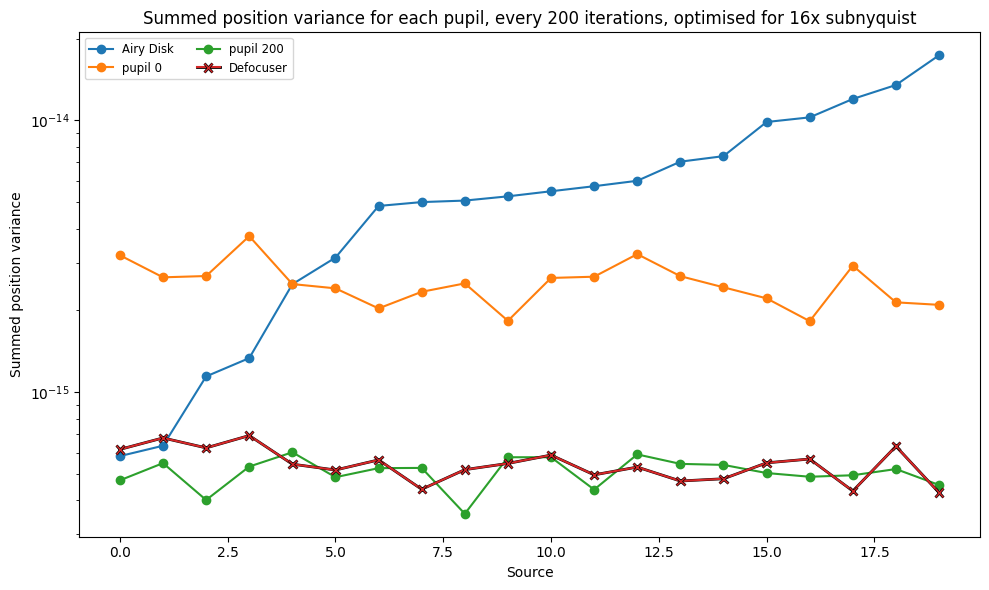

In [44]:
import matplotlib.patheffects as pe
path_effects = [pe.Stroke(linewidth=2, foreground='k'), pe.Normal()]

arr= np.asarray([np.asarray(t) for t in trace_covs])

arr = arr.T
n_optics, n_sources = arr.shape

# compute permutation that sorts sources by increasing traces_airy
order = np.argsort(traces_airy)    # indices of sources in increasing Airy-trace order

# reorder Airy and arr columns

traces_airy_sorted = traces_airy[order]
arr_sorted = arr[:, order]           # now shape still (n_optics, n_sources)
defocus_sorted = traces_defocus[order]

plt.figure(figsize=(10, 6))
plt.plot(traces_airy_sorted, label='Airy Disk', marker='o')

for i in range(n_optics):
    plt.plot(arr_sorted[i], marker='o', label=f'pupil {200*i}')   # change label if you want index meaning

plt.plot(defocus_sorted, label='Defocuser', marker='x', path_effects=path_effects)

plt.xlabel("Source")
plt.ylabel("Summed position variance")
plt.title("Summed position variance for each pupil, every 200 iterations, optimised for 16x subnyquist")
plt.yscale('log')
#plt.xticks(x, labels, rotation=45, ha='right')
plt.legend(ncol=2, fontsize='small')
#plt.grid(True)
plt.tight_layout()
plt.show()

# gotta optimise a bit better than that if we want to beat the defocuser!

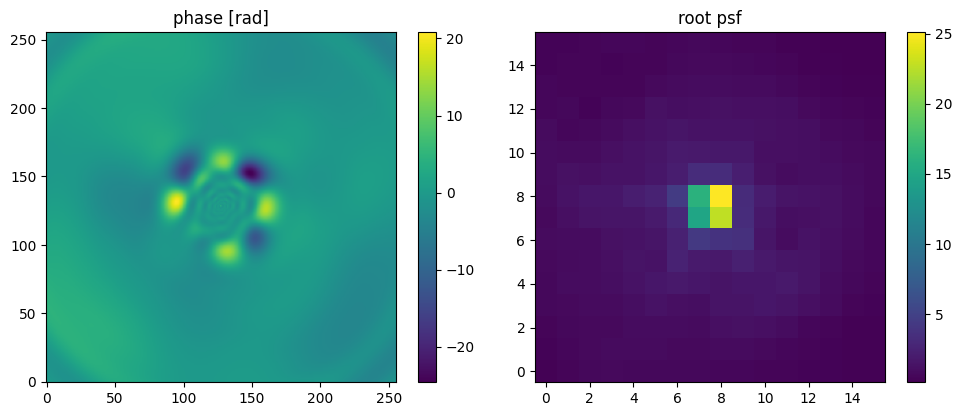

In [42]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title('phase [rad]')
plt.imshow(dlu.opd2phase(dlu.downsample(models_out[-1].get_total_opd(),3,True),585e-9))
plt.colorbar()

plt.subplot(1,2,2)
plt.title('root psf')
plt.imshow(dlu.downsample(models_out[-1].propagate_mono(585e-9)**0.5,64,False))
# plt.xlim(512-256,512+256)
# plt.ylim(512-256,512+256)
plt.colorbar()

plt.tight_layout()
plt.show()

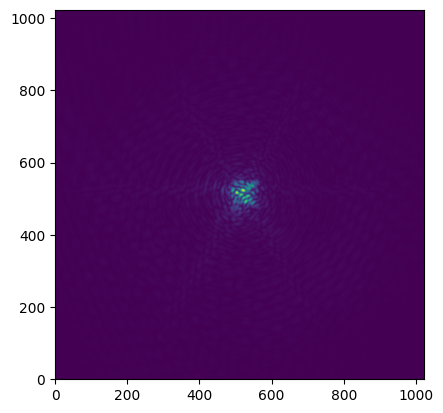

In [46]:

plt.imshow(dlu.downsample(models_out[-1].propagate_mono(585e-9)**0.5,1,False))
plt.show()

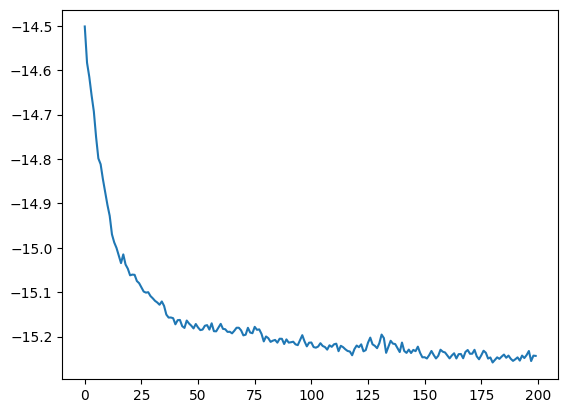

In [45]:
plt.plot(losses)